# Mateusz Kuchta nr 116111
## Model XGBoost dla predykcji zajścia zdarzenia default
###### 15.08.2023

### Rozpoczęto od instalacji niezbędnych pakietów

In [1]:
# !pip install xgboost
# !pip install category_encoders

### Kolejnym krokiem jest import zastosowanych bibliotek

In [27]:
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score, KFold

### Wczytano zbiór danych
#### Do budowy modelu zastosowano zbiór wykorzystywany podczas zajęć z przedmiotu "Credit scoring - automatyzacja procesu biznesowego" prowadzonego w Szkole Głównej Handlowej w Warszawie, prowadzonego przez Pana dr Karola Przanowskiego, dzięki którego uprzejmości dataset może zostać użyty w pracy.
#### Zbiór zawiera 219 zmiennych, zarówno ciągłych, jak i kategorycznych. Umieszczono w nim 68499 obserwacji, gdzie każda z nich dotyczy innej aplikacji o produkt gotówkowy (product = 'css') lub ratalny (product = 'ins')

In [3]:
source_data = pd.read_sas('abt_app.sas7bdat', encoding = 'LATIN2')
data = source_data.copy()
print("Zaimportowany zbiór danych wraz z jego rozmiarem:", data.shape)
data.head(5)

Zaimportowany zbiór danych wraz z jego rozmiarem: (68499, 219)


,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,default3,default6,default9,default12,default_cross3,default_cross6,default_cross9,default_cross12,cross_app_loan_amount,cross_app_n_installments
0,0000000001,css1970020500001,css,197002,59.0,0.492428,2.442599,2047.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000060,css1970020700004,css,197002,52.0,0.447902,1.023541,4885.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000013,css1970021100003,css,197002,38.0,0.586847,8.431703,593.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000089,css1970022400005,css,197002,37.0,0.165007,2.370792,2109.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000005,css1970022600002,css,197002,46.0,0.529964,1.805054,2770.0,5000.0,24.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5000.0,24.0


### Zdefiniowano globalne parametry
#### Jako zmienną celu wybrano 'default12' - binarny wskaźnik zajścia zdarzenia, w którym klient w trakcie pierwszych 12 miesięcy od otrzymania kredytu spóźnił się ze spłatą rat sumarycznie o co najmniej 90 dni

In [4]:
target_variable = 'default12'

#### Zdefiniowano benchmarki, które powinny być przestrzegane przez finalnie wybrany model. Zmienna 'gini_benchmark' wskazuje minimalny współczynnik Gini'ego dla modelu, zarówno dla zbioru testowego, jak i treningowego, natomiast zmienna 'gini_diff_benchmark' określa maksymalną różnicę pomiędzy współczynnikami Gini'ego w zbiorze treningowym, a Gini'm na zbiorze testowym, dla jednego modelu

In [5]:
gini_benchmark = 0.8
gini_diff_benchmark = 0.04

### Przetwarzanie zbioru danych
#### Zdecydowano się na ograniczenie zakresu modelu do jednego produktu - kredytu gotówkowego. Spowodowane jest to różną charakterystyką danych znanych w momencie aplikacji o tzw. "gotówkę" w odniesieniu do pożyczki ratalnej. Operacja ta obniżyła liczbę obserwacji do 34188.

In [6]:
data_css = data.loc[data['product'] == 'css'].copy()
print("Rozmiar zbioru danych dla produktu 'css':", data_css.shape)

Rozmiar zbioru danych dla produktu 'css': (34188, 219)


#### Po analizie rozkładu wartości binarnej zmiennej celu stwierdzono, w zbiorze znajduje się dostatecznie dużo "default'ów" (w literaturze można znaleźć informację, że do budowy poprawnego modelu scoring'owego wymagane jest posiadanie w analizowanym zbiorze co najmniej 300 dłużników).

In [7]:
print("Rozkład wartości zmiennej celu w zbiorze danych dla produktu 'css':")
print(data_css[target_variable].value_counts())
print("Liczba braków danych zmiennej celu w zbiorze danych dla produktu 'css':",
      data_css[target_variable].isnull().sum())

Rozkład wartości zmiennej celu w zbiorze danych dla produktu 'css':
1.0    19986
0.0     9791
Name: default12, dtype: int64
Liczba braków danych zmiennej celu w zbiorze danych dla produktu 'css': 4411


#### Ze zbioru pozbyto się obserwacji, w których odnotowano braki danych. Jest ich dużo, jeśli chodzi o wartość bezwzględną, jednakże uwzględniając rozmiar całego zestawu danych, nie uwzględnianie tych informacji nie powinno zaszkodzić modelowi. Dodatkowo, posortowano dane względem zmiennej 'aid'.

In [8]:
data_css.dropna(subset = [target_variable], inplace = True)
data_css.sort_values(by = ['aid'], inplace = True)
print(" Rozmiar zbioru danych dla produktu 'css'\n", 
      "po wyeliminowaniu obserwacji z brakami danych w tej zmiennej:", data_css.shape)

 Rozmiar zbioru danych dla produktu 'css'
 po wyeliminowaniu obserwacji z brakami danych w tej zmiennej: (29777, 219)


### Przetwarzanie zmiennych
#### Znając logikę nazewnictwa zmiennych w zbiorze, utworzono listę nazw zmiennych dla przedrostków 'app', 'act', 'agr' oraz 'ags'

In [9]:
variables = [variable for variable in list(data_css) 
             if any(variable.casefold().startswith(prefix) for prefix in ['app', 'act', 'agr', 'ags'])]
print('Liczba zmiennych spełniających warunek określonego przedrostka =', len(variables))

Liczba zmiennych spełniających warunek określonego przedrostka = 201


#### Konieczne jest rozdzielenie zmiennych ze względu na ich zawartość - na zmienne jakościowe(char) oraz ilościowe(num)

In [10]:
variables_char_list = list(data_css[variables].select_dtypes(include = 'object'))
variables_num_list = list(data_css[variables].select_dtypes(include = 'number'))
print('Liczba zmiennych jakościowych =', len(variables_char_list))
print('Liczba zmiennych ilościowych =', len(variables_num_list))

Liczba zmiennych jakościowych = 7
Liczba zmiennych ilościowych = 194


#### Model XGBoost nie jest w stanie operować na zmiennych jakościowych, co wymusza konieczność zastosowania kodowania\kategoryzacji tychże zmiennych. W tym celu skorzystano z pakietu category_encoders mającego możliwość kodowania binarnego. 7 zmiennych jakościowych zostało poddane temu procesowi, na skutek czego powstało 16 nowych zmiennych binarnych.

In [11]:
encoding = ce.BinaryEncoder(cols = variables_char_list)
data_encoded = encoding.fit_transform(data_css[variables_char_list])
variables_char_encoded_list = list(data_encoded)
print("Lista", len(variables_char_encoded_list),"zbinowanych zmiennych jakościowych:")
variables_char_encoded_list

Lista 16 zbinowanych zmiennych jakościowych:


['app_char_branch_0',
 'app_char_gender_0',
 'app_char_gender_1',
 'app_char_job_code_0',
 'app_char_job_code_1',
 'app_char_job_code_2',
 'app_char_marital_status_0',
 'app_char_marital_status_1',
 'app_char_marital_status_2',
 'app_char_city_0',
 'app_char_city_1',
 'app_char_city_2',
 'app_char_home_status_0',
 'app_char_home_status_1',
 'app_char_cars_0',
 'app_char_cars_1']

#### Nowo powstałe zmienne dołączono do zbioru pełnego dla produktu 'css', tworząc nowy zbiór 'data_full'

In [12]:
data_full = pd.concat([data_css, data_encoded], axis = 1, join = 'inner')
print("Nowy zbiór danych, powstały z połączenia zbioru oryginalnego dla produktu gotówkowego")
print("oraz zbioru składającego się z nowo utworzonych zmiennych binarnych:")
data_full

Nowy zbiór danych, powstały z połączenia zbioru oryginalnego dla produktu gotówkowego
oraz zbioru składającego się z nowo utworzonych zmiennych binarnych:


,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,app_char_marital_status_0,app_char_marital_status_1,app_char_marital_status_2,app_char_city_0,app_char_city_1,app_char_city_2,app_char_home_status_0,app_char_home_status_1,app_char_cars_0,app_char_cars_1
0,0000000001,css1970020500001,css,197002,59.0,0.492428,2.442599,2047.0,5000.0,24.0,...,0,0,1,0,0,1,0,1,0,1
1,0000000060,css1970020700004,css,197002,52.0,0.447902,1.023541,4885.0,5000.0,24.0,...,0,0,1,0,1,0,1,0,0,1
2,0000000013,css1970021100003,css,197002,38.0,0.586847,8.431703,593.0,5000.0,24.0,...,0,0,1,0,1,1,0,1,0,1
3,0000000089,css1970022400005,css,197002,37.0,0.165007,2.370792,2109.0,5000.0,24.0,...,0,0,1,0,1,0,0,1,0,1
4,0000000005,css1970022600002,css,197002,46.0,0.529964,1.805054,2770.0,5000.0,24.0,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34183,0000009715,css1988122500162,css,198812,86.0,0.234753,2.876870,1738.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,1,0
34184,0000017452,css1988122500175,css,198812,72.0,0.729145,5.149331,971.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,0,1
34185,0000000040,css1988122600002,css,198812,84.0,0.405874,3.337784,1498.0,5000.0,24.0,...,0,1,0,0,0,1,0,1,1,0
34186,0000000081,css1988122600006,css,198812,93.0,0.624339,4.409171,1134.0,5000.0,24.0,...,0,1,0,0,1,0,0,1,0,1


#### Utworzono dwie listy zmiennych - pierwsza, zawierająca jedynie zmienne numeryczne oraz zmienne jakościowe binowane; druga, składająca się dodatkowo ze zmiennej celu, zmiennej czasowej oraz identyfikatora

In [13]:
variables_full_wo_target = variables_num_list + variables_char_encoded_list
variables_full = variables_num_list + variables_char_encoded_list + [target_variable] + ['period'] + ['aid']
print("Liczba zmiennych używanych do budowy modelu:", len(variables_full))

Liczba zmiennych używanych do budowy modelu: 213


### Budowa modelu XGBoost

#### Budowę modelu rozpoczęto od podziału przygotowanego zestawu danych na zbiór testowy oraz treningowy w proporcjach 30/70

In [28]:
train, test = train_test_split(data_full[variables_full], random_state = 2001, test_size = 0.3)
print("Rozmiar zbioru treningowego:", train.shape)
print("Rozmiar zbioru testowego:", test.shape)

Rozmiar zbioru treningowego: (20843, 213)
Rozmiar zbioru testowego: (8934, 213)


#### Wprowadzono zmienne X oraz Y dla zbioru testowego i treningowego, gdzie Y zawiera zmienną objaśnianą, natomiast X składa się ze zmiennych objaśniających

In [29]:
X_train = train[variables_full_wo_target]
Y_train = train[target_variable]
X_test = test[variables_full_wo_target]
Y_test = test[target_variable]

#### Model XGBoost wymaga ściśle określonej struktury danych. Aby to uzyskać, wykorzystano funkcję z pakietu xgboost o nazwie 'xgboost.DMatrix'

In [30]:
xdm_train = xgb.DMatrix(X_train, Y_train, missing = True)
xdm_test  = xgb.DMatrix(X_test, Y_test, missing = True)

#### Kolejnym etapem było wytrenowanie modelu na zbiorze treningowym, a następnie jego walidacja na zbiorze testowym. Przeprowadzono szereg treningów i walidacji celem znalezienia najlepszego modelu, w tym celu manipulując parametrami uczenia.
#### W następnym kroku użyto nauczonego modelu do utworzenia nowych zmiennych, w których przechowywano klasyfikację wykonaną przez XGBoost
#### Finalnie podsumowano obliczeniem mocy predykcyjnej modelu dla zbioru testowego i treningowego wyliczając współczynnik GINI przy pomocy funkcji roc_auc_score z biblioteki sklearn

#### Pierwszy zbudowany model, stanowił element poglądowy do dalszej analizy. Jego głównym celem, było zbudowanie prostego modelu XGBoost na przygotowanych danych, celem zgrubnego oszacowania istotności zmiennych przy pomocy statystyki F-score

GINI TRAIN =  89.71%
GINI TEST =  80.04%
GINI DIFF =  9.67%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

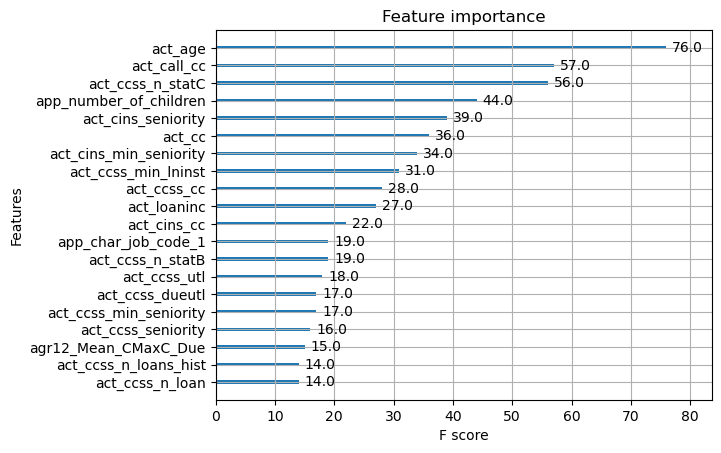

In [31]:
            M_premodel = xgb.train(  
                            {   
                                'max_depth' : 6, 
                                'seed' : 1998, 
                                'objective' : 'binary:logitraw',
                                'learning_rate' : 0.3,
                                'min_split_loss' : 0, 
                                'eval_metric' : 'auc'
                            },
                            xdm_train, 
                            num_boost_round = 20, 
                            evals = [
                                        (xdm_test, 'eval'), 
                                        (xdm_train, 'train')
                                    ],
                            verbose_eval = 0
                        )

            Y_M_train_premodel = M_premodel.predict(xdm_train)
            Y_M_test_premodel = M_premodel.predict(xdm_test)

            GINI_train_premodel = 2 * roc_auc_score(Y_train, Y_M_train_premodel) - 1
            GINI_test_premodel  = 2 * roc_auc_score(Y_test, Y_M_test_premodel) - 1

print('GINI TRAIN = ', '{:.2%}'.format(GINI_train_premodel))
print('GINI TEST = ', '{:.2%}'.format(GINI_test_premodel))
print('GINI DIFF = ', '{:.2%}'.format(GINI_train_premodel - GINI_test_premodel))
xgb.plot_importance(M_premodel, max_num_features = 20)

[21:01:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[21:01:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[21:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[21:01:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[21:01:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

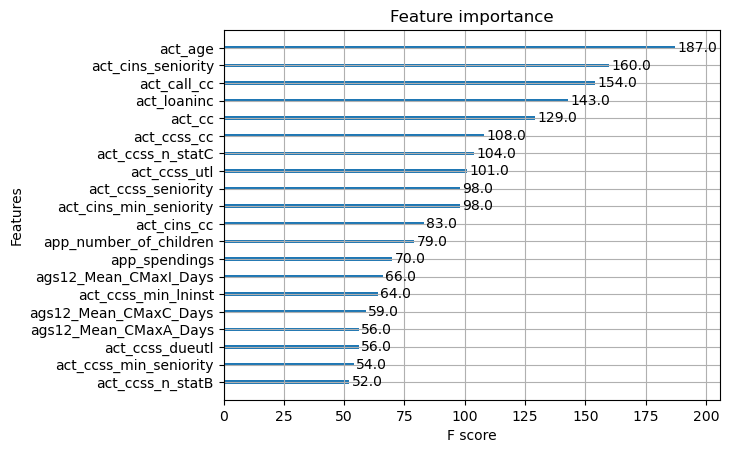

In [35]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score

# Podział danych na zbiór treningowy i testowy
train, test = train_test_split(data_full[variables_full], random_state=2001, test_size=0.3)
X = train[variables_full_wo_target]
y = train[target_variable]

# Definicja modelu XGBoost
model = xgb.XGBClassifier(
    max_depth=6,
    seed=1998,
    objective='binary:logitraw',
    learning_rate=0.3,
    min_split_loss=0,
    eval_metric='auc',
    num_boost_round=20
)

# Przygotowanie obiektu do kroswalidacji K-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Przeprowadzenie cross-walidacji
results = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')

# Obliczenie średniej i odchylenia standardowego wyników
mean_auc = np.mean(results)
std_auc = np.std(results)

print(f'Średni wynik AUC: {mean_auc:.2f}')
print(f'Odchylenie standardowe wyników AUC: {std_auc:.2f}')

# Możesz również wyświetlić wynik AUC dla każdej iteracji kroswalidacji, jeśli jest to potrzebne
for i, auc in enumerate(results):
    print(f'AUC dla foldu {i+1}: {auc:.2f}')

# Ostatecznie, możesz wykorzystać model M_premodel po treningu na całym zbiorze treningowym
model.fit(X, y)

# Wyświetlenie wyników na zbiorze testowym
X_test = test[variables_full_wo_target]
Y_test = test[target_variable]

Y_M_test_premodel = model.predict_proba(X_test)[:, 1]
GINI_test_premodel = 2 * roc_auc_score(Y_test, Y_M_test_premodel) - 1

print('GINI TEST = ', '{:.2%}'.format(GINI_test_premodel))

# Wykres ważności cech
xgb.plot_importance(model, max_num_features=20)

### Analiza eksploracyjna zmiennych
#### Przeanalizowano 3 najważniejsze zmienne, opierając się na wskazaniach statystyki Feature Importance wygenerowanej na podstawie modelu wstępnego
#### Na wstępie stworzono dwa podzbiory, podzielone ze względu na wartość zmiennej celu

In [18]:
data0 = data_full.loc[data_full['default12'] == 0].copy()
data1 = data_full.loc[data_full['default12'] == 1].copy()

#### Jako pierwszą przeanalizowano zmienną act_age, oznaczającej wiek klienta w momencie składania wniosku kredytowego

In [19]:
print(data0['act_age'].describe())
print("Liczba braków danych w zmiennej 'act_age' w zbiorze 'data0' jest równa:", 
      data0['act_age'].isnull().sum())

count    9791.000000
mean       63.028904
std        11.340882
min        30.000000
25%        55.000000
50%        63.000000
75%        71.000000
max        93.000000
Name: act_age, dtype: float64
Liczba braków danych w zmiennej 'act_age' w zbiorze 'data0' jest równa: 0


In [26]:
alpha = 0.05  # Poziom istotności
contingency_table = pd.crosstab(data_full['act_age'], data_full['default12'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Wartość statystyki Chi-kwadrat dla zmiennej act_age:", chi2)
print("Wartość p-value:", p)
if p < alpha:
    print("Zmienna 'act_age' jest istotna względem zmiennej 'default12'")
else:
    print("Zmienna 'act_age' nie jest istotna względem zmiennej 'default12'")

Wartość statystyki Chi-kwadrat dla zmiennej act_age: 186.85737675770173
Wartość p-value: 4.978645314537384e-13
Zmienna 'act_age' jest istotna względem zmiennej 'default12'


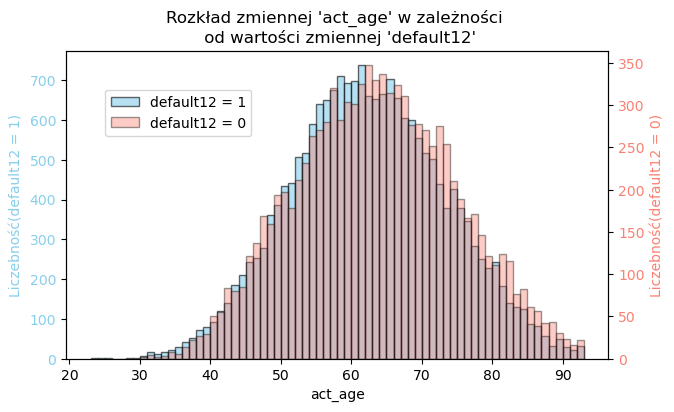

In [21]:
fig, wyk1 = plt.subplots(figsize=(7, 4))

wyk1.hist(data1['act_age'], bins = 70, alpha = 0.6, label = 'default12 = 1', 
          color = 'skyblue', edgecolor = 'black')
wyk1.set_xlabel('act_age')
wyk1.set_ylabel('Liczebność(default12 = 1)', color = 'skyblue')
wyk1.tick_params(axis = 'y', labelcolor = 'skyblue')

wyk2 = wyk1.twinx()
wyk2.hist(data0['act_age'], bins = 63, alpha = 0.4, label = 'default12 = 0', 
          color = 'salmon', edgecolor = 'black')
wyk2.set_ylabel('Liczebność(default12 = 0)', color = 'salmon')
wyk2.tick_params(axis = 'y', labelcolor = 'salmon')

plt.title("Rozkład zmiennej 'act_age' w zależności \n od wartości zmiennej 'default12'")
fig.legend(loc='upper right', bbox_to_anchor=(0.4, 0.8))
plt.show()

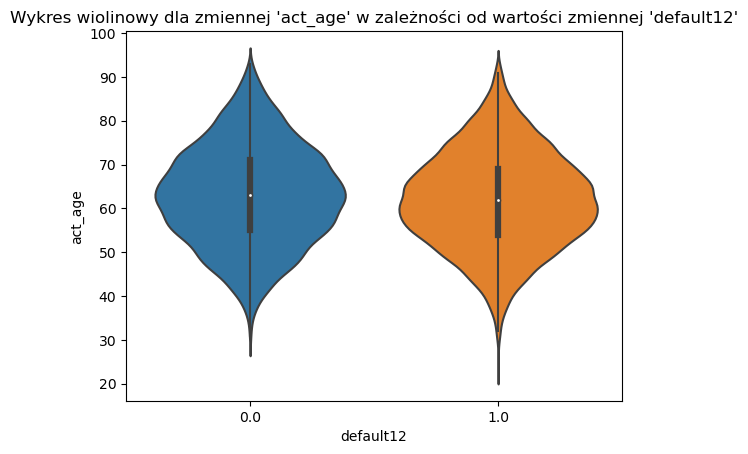

In [22]:
sns.violinplot(x='default12', y='act_age', data=data_full)
plt.title("Wykres wiolinowy dla zmiennej 'act_age' w zależności od wartości zmiennej 'default12'")
plt.show()

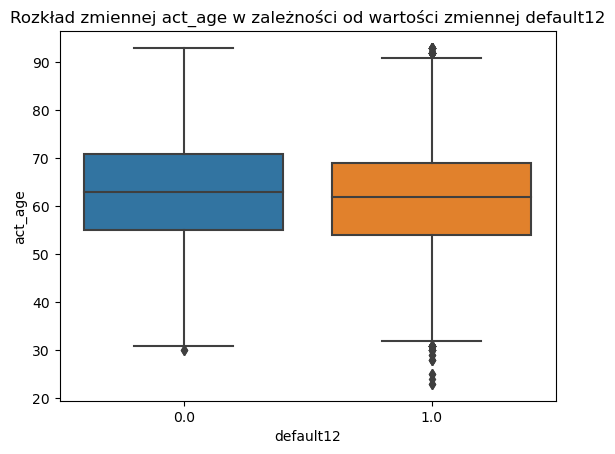

In [23]:
sns.boxplot(x='default12', y='act_age', data=data_full)
plt.title("Rozkład zmiennej act_age w zależności od wartości zmiennej default12")
plt.show()

#### Jako drugą przeanalizowano zmienną act_call_cc, oznaczającą sumę potencjalnych rat kredytu i wydatków w stosunku do dochodów klienta

In [24]:
print(data0['act_call_cc'].describe())
print("Liczba braków danych w zmiennej 'act_call_cc' w zbiorze 'data0' jest równa:", 
      data0['act_call_cc'].isnull().sum())

count    9791.000000
mean        0.925345
std         0.436998
min         0.099325
25%         0.628913
50%         0.851278
75%         1.126885
max         4.622150
Name: act_call_cc, dtype: float64
Liczba braków danych w zmiennej 'act_call_cc' w zbiorze 'data0' jest równa: 0


In [25]:
print(data1['act_call_cc'].describe())
print("Liczba braków danych w zmiennej 'act_call_cc' w zbiorze 'data1' jest równa:", 
      data1['act_call_cc'].isnull().sum())

count    19986.000000
mean         1.141037
std          0.590710
min          0.075747
25%          0.721041
50%          1.010427
75%          1.423545
max          6.964356
Name: act_call_cc, dtype: float64
Liczba braków danych w zmiennej 'act_call_cc' w zbiorze 'data1' jest równa: 0


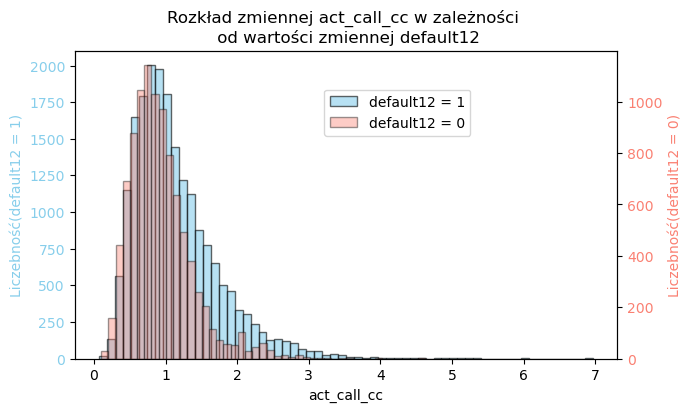

In [26]:
fig, wyk1 = plt.subplots(figsize=(7, 4))

wyk1.hist(data1['act_call_cc'], bins = 62, alpha = 0.6, label = 'default12 = 1', 
          color = 'skyblue', edgecolor = 'black')
wyk1.set_xlabel('act_call_cc')
wyk1.set_ylabel('Liczebność(default12 = 1)', color = 'skyblue')
wyk1.tick_params(axis = 'y', labelcolor = 'skyblue')

wyk2 = wyk1.twinx()
wyk2.hist(data0['act_call_cc'], bins = 45, alpha = 0.4, label = 'default12 = 0', 
          color = 'salmon', edgecolor = 'black')
wyk2.set_ylabel('Liczebność(default12 = 0)', color = 'salmon')
wyk2.tick_params(axis = 'y', labelcolor = 'salmon')

plt.title('Rozkład zmiennej act_call_cc w zależności \n od wartości zmiennej default12')
fig.legend(loc='upper right', bbox_to_anchor=(0.7, 0.8))
plt.show()

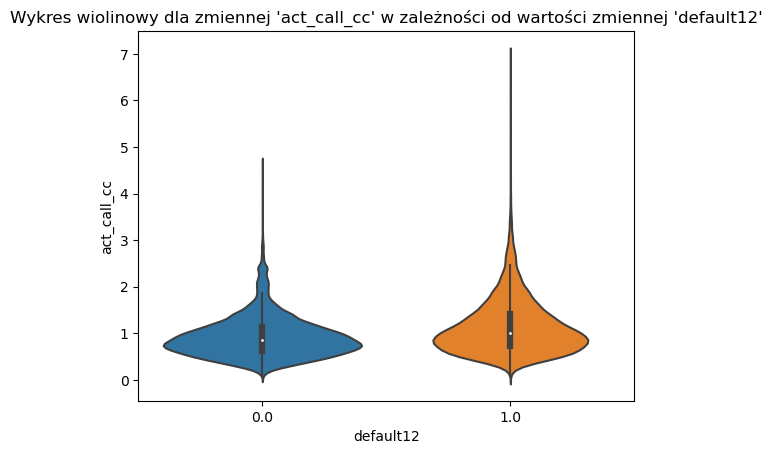

In [27]:
sns.violinplot(x='default12', y='act_call_cc', data=data_full)
plt.title("Wykres wiolinowy dla zmiennej 'act_call_cc' w zależności od wartości zmiennej 'default12'")
plt.show()

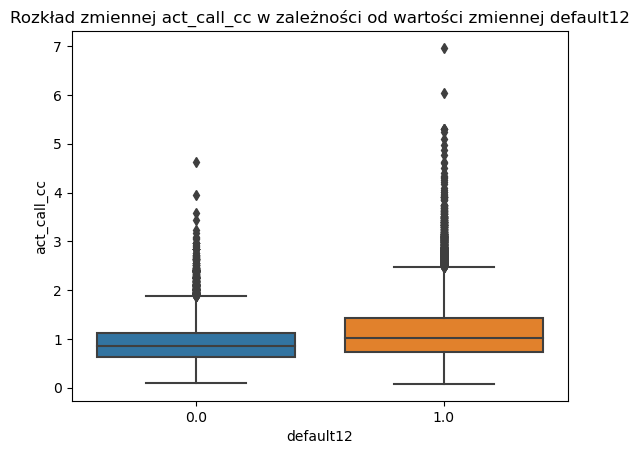

In [28]:
sns.boxplot(x='default12', y='act_call_cc', data=data_full)
plt.title("Rozkład zmiennej act_call_cc w zależności od wartości zmiennej default12")
plt.show()

#### Następnie zbadano zmienną act_ccss_n_statC, oznaczającej liczbę poprawnie w pełni spłaconych zobowiązań klienta w momencie składania wniosku kredytowego

In [29]:
print(data0['act_ccss_n_statC'].describe())
print("Liczba braków danych w zmiennej 'act_ccss_n_statC' w zbiorze 'data0' jest równa:", 
      data0['act_ccss_n_statC'].isnull().sum())

count    7889.000000
mean        6.196096
std        10.407138
min         0.000000
25%         0.000000
50%         1.000000
75%         7.000000
max        48.000000
Name: act_ccss_n_statC, dtype: float64
Liczba braków danych w zmiennej 'act_ccss_n_statC' w zbiorze 'data0' jest równa: 1902


In [30]:
print(data1['act_ccss_n_statC'].describe())
print("Liczba braków danych w zmiennej 'act_ccss_n_statC' w zbiorze 'data1' jest równa:", 
      data1['act_ccss_n_statC'].isnull().sum())

count    18894.000000
mean         2.110194
std          3.654164
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         43.000000
Name: act_ccss_n_statC, dtype: float64
Liczba braków danych w zmiennej 'act_ccss_n_statC' w zbiorze 'data1' jest równa: 1092


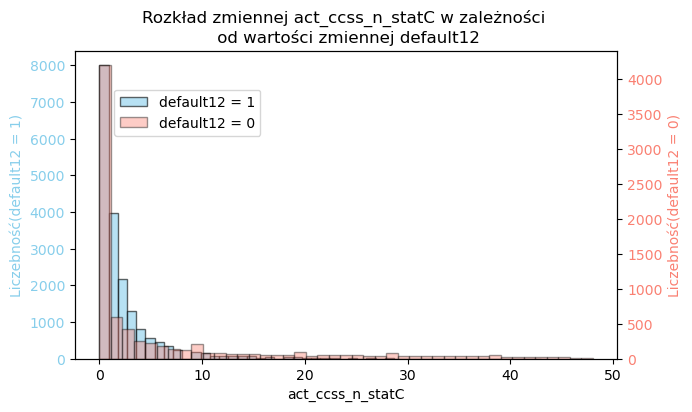

In [31]:
fig, wyk1 = plt.subplots(figsize=(7, 4))

wyk1.hist(data1['act_ccss_n_statC'], bins = 48, alpha = 0.6, label = 'default12 = 1', 
          color = 'skyblue', edgecolor = 'black')
wyk1.set_xlabel('act_ccss_n_statC')
wyk1.set_ylabel('Liczebność(default12 = 1)', color = 'skyblue')
wyk1.tick_params(axis = 'y', labelcolor = 'skyblue')

wyk2 = wyk1.twinx()
wyk2.hist(data0['act_ccss_n_statC'], bins = 43, alpha = 0.4, label = 'default12 = 0', 
          color = 'salmon', edgecolor = 'black')
wyk2.set_ylabel('Liczebność(default12 = 0)', color = 'salmon')
wyk2.tick_params(axis = 'y', labelcolor = 'salmon')

plt.title('Rozkład zmiennej act_ccss_n_statC w zależności \n od wartości zmiennej default12')
fig.legend(loc='upper right', bbox_to_anchor=(0.4, 0.8))
plt.show()

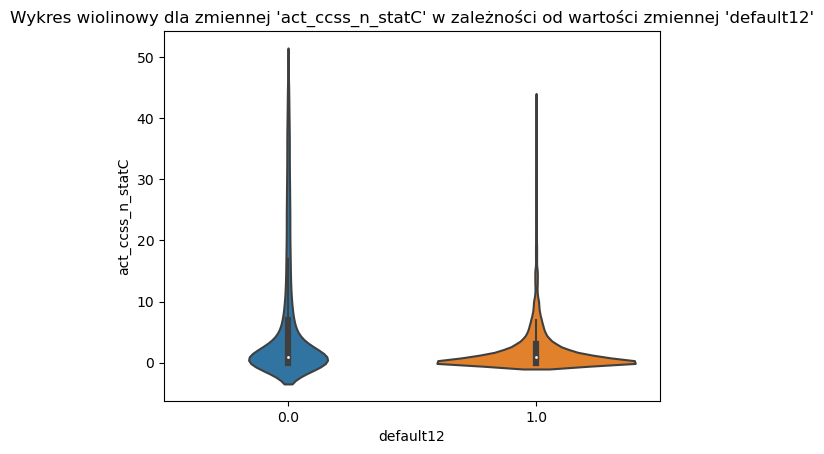

In [32]:
sns.violinplot(x='default12', y='act_ccss_n_statC', data=data_full)
plt.title("Wykres wiolinowy dla zmiennej 'act_ccss_n_statC' w zależności od wartości zmiennej 'default12'")
plt.show()

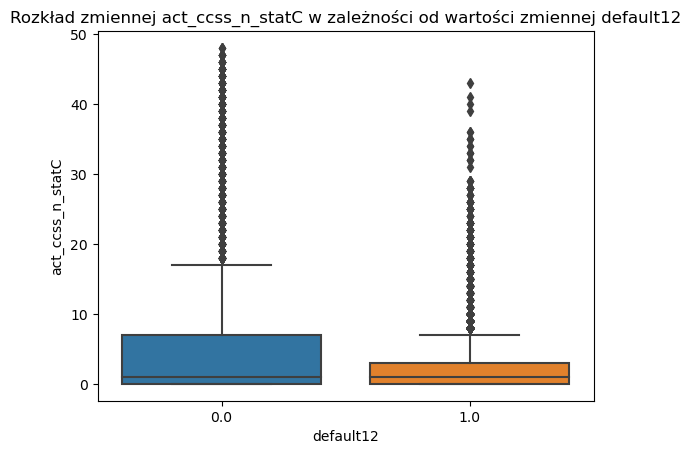

In [33]:
sns.boxplot(x='default12', y='act_ccss_n_statC', data=data_full)
plt.title("Rozkład zmiennej act_ccss_n_statC w zależności od wartości zmiennej default12")
plt.show()

#### Po przeanalizowaniu ważności zmiennych, dokonano iteracyjnego, wielokrotnego trenowania modeli z różnymi parametrami dostępnymi w pakiecie xgboost. Następnie przeprowadzono analizę współczynników Giniego dla zbioru testowego oraz treningowego, a także określono różnicę między tymi wartościami dla poszczególnych modeli. 

In [34]:
df = pd.DataFrame( 
                    {
                        'GINI_train' : [],
                        'GINI_test' : [],
                        'max_depth' : [],
                        'learning_rate' : [],
                        'min_split_loss' : [],
                        'GINI_diff' : []
                    }
                 )

for i in range(3):
    for j in range(5):
        for k in range(5):
            M = xgb.train(  
                            {   
                                'max_depth' : i+3, 
                                'seed' : 1998, 
                                'objective' : 'binary:logitraw',
                                'learning_rate' : 0.1 * (j + 5),
                                'min_split_loss' : k + 3, 
                                'eval_metric' : 'auc'
                            },
                            xdm_train, 
                            num_boost_round = 1000, 
                            evals = [
                                        (xdm_test, 'eval'), 
                                        (xdm_train, 'train')
                                    ],
                            verbose_eval = 0
                        )

            Y_M_train = M.predict(xdm_train)
            Y_M_test = M.predict(xdm_test)

            GINI_train = 2 * roc_auc_score(Y_train, Y_M_train) - 1
            GINI_test  = 2 * roc_auc_score(Y_test, Y_M_test) - 1

            df.loc[len(df)] =   {
                                    'GINI_train': GINI_train, 
                                    'GINI_test': GINI_test, 
                                    'max_depth': i + 3, 
                                    'learning_rate': 0.1 * (j + 5),
                                    'min_split_loss' : k + 3,
                                    'GINI_diff': abs(GINI_train - GINI_test)
                                }
df

,GINI_train,GINI_test,max_depth,learning_rate,min_split_loss,GINI_diff
0,0.919049,0.808708,3,0.5,3,0.110342
1,0.906694,0.809080,3,0.5,4,0.097614
2,0.870871,0.810646,3,0.5,5,0.060225
3,0.865132,0.812724,3,0.5,6,0.052408
4,0.852832,0.812864,3,0.5,7,0.039968
...,...,...,...,...,...,...
70,0.989431,0.751668,5,0.9,3,0.237762
71,0.981923,0.752477,5,0.9,4,0.229446
72,0.952166,0.768741,5,0.9,5,0.183425
73,0.940029,0.776951,5,0.9,6,0.163078


#### Najlepszy model wybrano dobierając odpowiednie benchmarki

In [35]:
df_filtered = df.loc[(df['GINI_train'] > gini_benchmark) & 
                     (df['GINI_test'] > gini_benchmark) & 
                     (df['GINI_diff'] < gini_diff_benchmark)].copy()
df_filtered.sort_values(by = ['GINI_diff'], inplace = True)
df_filtered.head(1)

,GINI_train,GINI_test,max_depth,learning_rate,min_split_loss,GINI_diff
4,0.852832,0.812864,3,0.5,7,0.039968


#### Po wybraniu optymalnych parametrów modelu, zapisano go pod zmienną M_chosen_model

In [36]:
            M_chosen_model = xgb.train(  
                            {   
                                'max_depth' : 3, 
                                'seed' : 1998, 
                                'objective' : 'binary:logitraw',
                                'learning_rate' : 0.5,
                                'min_split_loss' : 7, 
                                'eval_metric' : 'auc'
                            },
                            xdm_train, 
                            num_boost_round = 1000, 
                            evals = [
                                        (xdm_test, 'eval'), 
                                        (xdm_train, 'train')
                                    ],
                            verbose_eval = 0
                        )

            Y_M_train_chosen_model = M_chosen_model.predict(xdm_train)
            Y_M_test_chosen_model = M_chosen_model.predict(xdm_test)

            GINI_train_chosen_model = 2 * roc_auc_score(Y_train, Y_M_train_chosen_model) - 1
            GINI_test_chosen_model  = 2 * roc_auc_score(Y_test, Y_M_test_chosen_model) - 1

print('GINI TRAIN = ', '{:.2%}'.format(GINI_train_chosen_model))
print('GINI TEST = ', '{:.2%}'.format(GINI_test_chosen_model))
print('GINI DIFF = ', '{:.2%}'.format(GINI_train_chosen_model - GINI_test_chosen_model))

GINI TRAIN =  85.28%
GINI TEST =  81.29%
GINI DIFF =  4.00%


### Wizualizacje
#### Zwizualizowano skuteczność modelu, przy pomocy krzywych ROC, zarówno dla zbiory treningowego, jak i testowego, celem porównania ich kształtu i wizualnej oceny stabilności klasyfikacji w zależności od znajomości danych
#### Dodatkowo, ponownie zweryfikowano ważność poszczególnych zmiennych, tym razem w finalnym modelu, celem porównania z modelem wstępnym

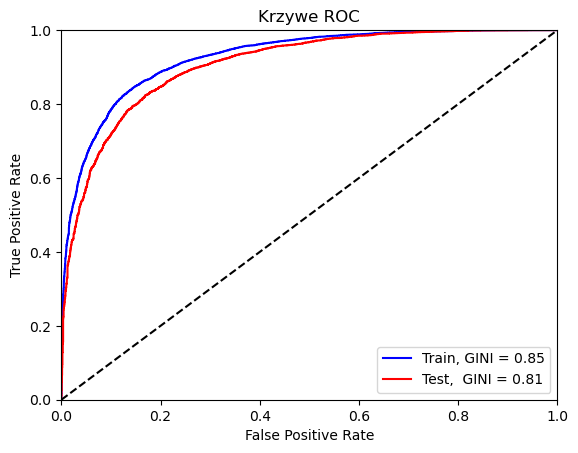

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

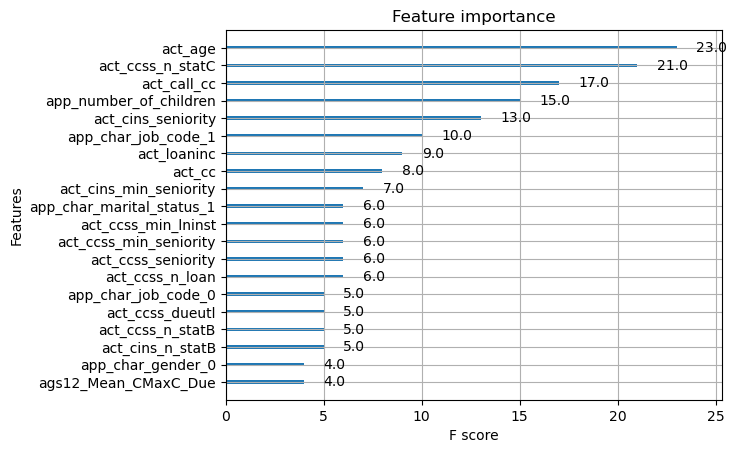

In [37]:
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train.values.ravel(), Y_M_train_chosen_model)
fpr_test,  tpr_test,  thresholds_test  = roc_curve(Y_test.values.ravel(), Y_M_test_chosen_model)
plt.plot(fpr_train, tpr_train, 'blue', label = 'Train, GINI = '+'{:4.2f}'.format(GINI_train_chosen_model))
plt.plot(fpr_test, tpr_test, 'red', label = 'Test,  GINI = '+'{:4.2f}'.format(GINI_test_chosen_model))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Krzywe ROC')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'k--')
plt.show()
xgb.plot_importance(M_chosen_model, max_num_features = 20)

### Postprocessing
#### Zapisano model do zewnętrznego pliku

In [38]:
M_chosen_model.save_model('XGBoostModel_MK116111_1.model')

### Adversarial Machine Learning
#### TEST 1 - zmiana wartości zmiennej celu dla pewnego % danych treningowych
#### W ramach tego testu, wybrano w zbiorze treningowym pewną część znajdujących się w nim obserwacji i zmieniono wartość zmiennej celu 'default12' na wartość odwrotną
#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [39]:
train_AML1, test_AML1 = train_test_split(data_full[variables_full], random_state = 2001, test_size = 0.3)
print("Rozmiar zbioru treningowego:", train_AML1.shape)
print("Rozmiar zbioru testowego:", test_AML1.shape)

Rozmiar zbioru treningowego: (20843, 213)
Rozmiar zbioru testowego: (8934, 213)


#### Wybrano zakres wartości procentowej zmienianych danych jako zmienną 'attacked_proc1', co dla "'attacked_proc1' = 15" oznacza, że wykonano 15 testów, gdzie kolejne wartości procentowe zmienionych danych znajdowały się w zakresie liczb całkowitych od 1 do 15

In [40]:
attacked_proc1 = 15

#### Zdefniowano ramkę danych 'df_AML1', w której były umieszczane statystyki dla kolejnych testów.
#### Następnie w pętli for dokonywano losowania liczby manipulowanych obserwacji, obliczając ją na podstawie zdefiniowanej wcześniej wartości 'attacked_proc1'. Dla wylosowanej próby dokonywano podmianę wartości zmiennej 'default12' bezpośrednio w zbiorze danych.
#### W kolejnym kroku dokonano standardowych operacji przygotowania zmanipulowanego zbioru do wykonania na nim procesu przetrenowania modelu, stosując parametry identyczne jak w modelu finalnym.
#### Po zweryfikowaniu przetrenowanych modeli na zbiorze walidacyjnym, statystyki współczynnika Gini'ego umieszczono w przygotowanej wcześniej ramce danych 'df_AML1'

In [41]:
df_AML1 = pd.DataFrame( 
                    {
                        'GINI_train' : [],
                        'GINI_test' : [],
                        'GINI_diff' : [],
                        '% atakowanych danych treningowych' : [],
                    }
                 )

for x in range(attacked_proc1 + 1):
    nofRows = math.ceil(x * len(train_AML1.index) / 100)
    train_AML_1_attacked = train_AML1.copy()
    attacked_sample1 = train_AML1.sample(n = nofRows, 
                                        random_state = 1234, 
                                        replace = False)

    for j in attacked_sample1.index:
        if train_AML1.loc[j, 'default12'] == 0:
            train_AML_1_attacked.loc[j, 'default12'] = 1
        else: train_AML_1_attacked.loc[j, 'default12'] = 0
            
    X_train_AML1 = train_AML_1_attacked[variables_full_wo_target]
    Y_train_AML1 = train_AML_1_attacked[target_variable]
    X_test_AML1 = test_AML1[variables_full_wo_target]
    Y_test_AML1 = test_AML1[target_variable]

    xdm_train_AML1 = xgb.DMatrix(X_train_AML1, Y_train_AML1, missing = True)
    xdm_test_AML1  = xgb.DMatrix(X_test_AML1, Y_test_AML1, missing = True)

    M_chosen_model_AML1 = xgb.train(  
        {   
            'max_depth' : 3, 
            'seed' : 1998, 
            'objective' : 'binary:logitraw',
            'learning_rate' : 0.5,
            'min_split_loss' : 7, 
            'eval_metric' : 'auc'
        },
        xdm_train_AML1, 
        num_boost_round = 1000, 
        evals = [
                    (xdm_test_AML1, 'eval'), 
                    (xdm_train_AML1, 'train')
                ],
        verbose_eval = 0
    )

    Y_M_train_chosen_model_AML1 = M_chosen_model_AML1.predict(xdm_train_AML1)
    Y_M_test_chosen_model_AML1 = M_chosen_model_AML1.predict(xdm_test_AML1)

    GINI_train_chosen_model_AML1 = 2 * roc_auc_score(Y_train_AML1, Y_M_train_chosen_model_AML1) - 1
    GINI_test_chosen_model_AML1  = 2 * roc_auc_score(Y_test_AML1, Y_M_test_chosen_model_AML1) - 1
    
    df_AML1.loc[len(df_AML1)] =   {
                'GINI_train': '{:.2%}'.format(GINI_train_chosen_model_AML1), 
                'GINI_test': '{:.2%}'.format(GINI_test_chosen_model_AML1), 
                'GINI_diff': '{:.2%}'.format(GINI_train_chosen_model_AML1 - GINI_test_chosen_model_AML1),
                '% atakowanych danych treningowych': '{:.0%}'.format(x/100)
                                }
df_AML1

,GINI_train,GINI_test,GINI_diff,% atakowanych danych treningowych
0,85.28%,81.29%,4.00%,0%
1,84.35%,81.24%,3.11%,1%
2,79.95%,80.57%,-0.62%,2%
3,79.55%,80.50%,-0.96%,3%
4,79.64%,80.44%,-0.80%,4%
5,75.36%,80.12%,-4.76%,5%
6,75.49%,79.88%,-4.39%,6%
7,74.79%,79.58%,-4.80%,7%
8,71.20%,79.18%,-7.98%,8%
9,67.97%,78.98%,-11.00%,9%


#### Wyniki badań przedstawiono na wykresie liniowym

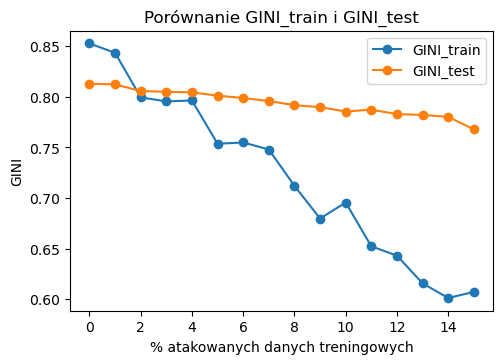

In [42]:
df_AML1_chart = df_AML1.copy()

df_AML1_chart['GINI_train'] = df_AML1_chart['GINI_train'].str.rstrip('%').astype('float') / 100
df_AML1_chart['GINI_test'] = df_AML1_chart['GINI_test'].str.rstrip('%').astype('float') / 100
df_AML1_chart['GINI_diff'] = df_AML1_chart['GINI_diff'].str.rstrip('%').astype('float') / 100
df_AML1_chart['% atakowanych danych treningowych'] = df_AML1_chart['% atakowanych danych treningowych'
                                                                  ].str.rstrip('%').astype('int')

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(df_AML1_chart['% atakowanych danych treningowych'], df_AML1_chart['GINI_train'], marker='o', label='GINI_train')
plt.plot(df_AML1_chart['% atakowanych danych treningowych'], df_AML1_chart['GINI_test'], marker='o', label='GINI_test')
plt.xlabel('% atakowanych danych treningowych')
plt.ylabel('GINI')
plt.title('Porównanie GINI_train i GINI_test')
plt.legend()

plt.show()

#### TEST 2 - wprowadzenie pewnego % skopiowanych danych ze zbioru treningowego do zbioru treningowego z odwróconymi wartościami.
#### W ramach tego testu, wybrano ze zbioru treningowego pewną część znajdujących się w nim obserwacji i zmieniono wartość zmiennej celu 'default12' na wartość odwrotną.
#### Następnie dodano te obserwacje do zbioru treningowego, co spowodowało obecność w tymże zbiorze par nierozróżnialnych obserwacji, różniących się wartością zmiennej celu
#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [43]:
train_AML2, test_AML2 = train_test_split(data_full[variables_full], random_state = 2001, test_size = 0.3)
print("Rozmiar zbioru treningowego:", train_AML2.shape)
print("Rozmiar zbioru testowego:", test_AML2.shape)

Rozmiar zbioru treningowego: (20843, 213)
Rozmiar zbioru testowego: (8934, 213)


#### Wybrano zakres wartości procentowej zmienianych danych jako zmienną 'attacked_proc2', gdzie "'attacked_proc2' = 15" oznacza, że wykonano 15 testów, gdzie kolejne wartości procentowe zmienionych danych znajdowały się w zakresie liczb całkowitych od 1 do 15

In [44]:
attacked_proc2 = 15

#### Zdefniowano ramkę danych 'df_AML2', w której były umieszczane statystyki dla kolejnych testów.
#### Następnie w pętli for dokonywano losowania liczby manipulowanych obserwacji, obliczając ją na podstawie zdefiniowanej wcześniej wartości 'attacked_proc2'. Dla wylosowanej próby dokonywano podmianę wartości zmiennej 'default12' i dodawano ją do zbioru treningowego.
#### W kolejnym kroku dokonano standardowych operacji przygotowania zmanipulowanego zbioru do wykonania na nim procesu przetrenowania modelu, stosując parametry identyczne jak w modelu finalnym.
#### Po zweryfikowaniu przetrenowanych modeli na zbiorze walidacyjnym, statystyki współczynnika Gini'ego umieszczono w przygotowanej wcześniej ramce danych 'df_AML2'

In [45]:
df_AML2 = pd.DataFrame( 
                    {
                        'GINI_train' : [],
                        'GINI_test' : [],
                        'GINI_diff' : [],
                        '% atakowanych danych treningowych' : [],
                    }
                 )

for x in range(attacked_proc2 + 1):
    nofRows = math.ceil(x * len(train_AML2.index) / 100)
    train_AML_2_attacked = train_AML2.drop(train_AML2.index)
    attacked_sample2 = train_AML2.sample(n = nofRows, random_state = 5678, replace = False)
    attacked_sample2.reset_index(drop=True, inplace=True)

    for j in range(len(attacked_sample2.index)):
        if attacked_sample2.loc[j, 'default12'] == 0:
            attacked_sample2.loc[j, 'default12'] = 1
        else: 
            attacked_sample2.loc[j, 'default12'] = 0
    
    train_AML_2_attacked = pd.concat([train_AML2, attacked_sample2])
    
    X_train_AML2 = train_AML_2_attacked[variables_full_wo_target]
    Y_train_AML2 = train_AML_2_attacked[target_variable]
    X_test_AML2 = test_AML2[variables_full_wo_target]
    Y_test_AML2 = test_AML2[target_variable]

    xdm_train_AML2 = xgb.DMatrix(X_train_AML2, Y_train_AML2, missing = True)
    xdm_test_AML2  = xgb.DMatrix(X_test_AML2, Y_test_AML2, missing = True)

    M_chosen_model_AML2 = xgb.train(  
        {   
            'max_depth' : 3, 
            'seed' : 1998, 
            'objective' : 'binary:logitraw',
            'learning_rate' : 0.5,
            'min_split_loss' : 7, 
            'eval_metric' : 'auc'
        },
        xdm_train_AML2, 
        num_boost_round = 1000, 
        evals = [
                    (xdm_test_AML2, 'eval'), 
                    (xdm_train_AML2, 'train')
                ],
        verbose_eval = 0
    )

    Y_M_train_chosen_model_AML2 = M_chosen_model_AML2.predict(xdm_train_AML2)
    Y_M_test_chosen_model_AML2 = M_chosen_model_AML2.predict(xdm_test_AML2)

    GINI_train_chosen_model_AML2 = 2 * roc_auc_score(Y_train_AML2, Y_M_train_chosen_model_AML2) - 1
    GINI_test_chosen_model_AML2  = 2 * roc_auc_score(Y_test_AML2, Y_M_test_chosen_model_AML2) - 1

    df_AML2.loc[len(df_AML2)] =   {
                'GINI_train': '{:.2%}'.format(GINI_train_chosen_model_AML2), 
                'GINI_test': '{:.2%}'.format(GINI_test_chosen_model_AML2), 
                'GINI_diff': '{:.2%}'.format(GINI_train_chosen_model_AML2 - GINI_test_chosen_model_AML2),
                '% atakowanych danych treningowych': '{:.0%}'.format(x/100)
                                    }
df_AML2

,GINI_train,GINI_test,GINI_diff,% atakowanych danych treningowych
0,85.28%,81.29%,4.00%,0%
1,83.05%,80.96%,2.09%,1%
2,81.41%,80.89%,0.52%,2%
3,79.86%,80.78%,-0.92%,3%
4,77.91%,80.61%,-2.70%,4%
5,75.19%,80.63%,-5.44%,5%
6,74.12%,80.10%,-5.98%,6%
7,71.98%,80.31%,-8.32%,7%
8,70.66%,80.53%,-9.87%,8%
9,69.75%,80.05%,-10.30%,9%


#### Wyniki badań przedstawiono na wykresie liniowym

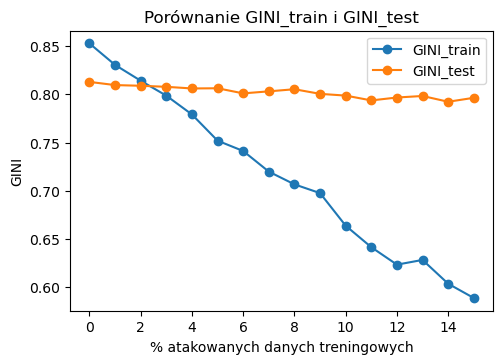

In [46]:
df_AML2_chart = df_AML2.copy()

df_AML2_chart['GINI_train'] = df_AML2_chart['GINI_train'].str.rstrip('%').astype('float') / 100
df_AML2_chart['GINI_test'] = df_AML2_chart['GINI_test'].str.rstrip('%').astype('float') / 100
df_AML2_chart['GINI_diff'] = df_AML2_chart['GINI_diff'].str.rstrip('%').astype('float') / 100
df_AML2_chart['% atakowanych danych treningowych'] = df_AML2_chart['% atakowanych danych treningowych'
                                                                  ].str.rstrip('%').astype('int')

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(df_AML2_chart['% atakowanych danych treningowych'], df_AML2_chart['GINI_train'], marker='o', label='GINI_train')
plt.plot(df_AML2_chart['% atakowanych danych treningowych'], df_AML2_chart['GINI_test'], marker='o', label='GINI_test')
plt.xlabel('% atakowanych danych treningowych')
plt.ylabel('GINI')
plt.title('Porównanie GINI_train i GINI_test')
plt.legend()

plt.show()

#### TEST 3 - manipulacja konkretną obserwacją/wnioskiem celem zmiany klasyfikacji modelu - atak na trzy zmienne jednocześnie

#### Atak na zmienne 'act_age', 'act_call_cc' oraz 'act_cins_seniority'

#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [47]:
train_AML3, test_AML3 = train_test_split(data_full[variables_full], random_state = 2001, test_size = 0.3)
print("Rozmiar zbioru treningowego:", train_AML3.shape)
print("Rozmiar zbioru testowego:", test_AML3.shape)

Rozmiar zbioru treningowego: (20843, 213)
Rozmiar zbioru testowego: (8934, 213)


#### Następnie wylosowano ze zbioru treningowego obserwacje, które będą poddane manipulacji celem zmiany ich klasyfikacji.
#### Rozpatrywano jedynie wnioski odrzucone ("default12 == 1"), jako że celem ataku jest zakwalifikowanie klienta potencjalnie niewiarygodnego, jako wiarygodnego.
#### Liczbę losowanych próbek dobrano w sposób taki, aby po odrzuceniu wylosowanych obserwacji, dla których wartość rzeczywista zmiennej 'default12' jest różna od klasyfikacji wynikającej z modelu finalnego, liczba modyfikowanych dalej obserwacji była równa 100.
#### Na końcu zresetowano numery wierszy w ramce danych, aby ułatwić iterowanie po niej.

In [48]:
train_AML3_zeros = train_AML3.query("default12 == 1").sample(n = 115, random_state = 3456, replace = False)
train_AML3_zeros.reset_index(drop=True, inplace=True)

In [49]:
X_train_preAML3 = train_AML3_zeros[variables_full_wo_target]
Y_train_preAML3 = train_AML3_zeros[target_variable]
xdm_train_preAML3 = xgb.DMatrix(X_train_preAML3, Y_train_preAML3, missing = True)

Y_M_train_chosen_model_preAML3 = M_chosen_model.predict(xdm_train_preAML3)


pre_rounded_predictions = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_preAML3]

pre_true_labels = train_AML3_zeros['default12']
accuracy = accuracy_score(pre_true_labels, pre_rounded_predictions)
print(f"Dokładność przewidywań: {accuracy:.2f}")

Dokładność przewidywań: 0.87


In [50]:
train_AML3_zeros.insert(0, "preModelResponse", pre_rounded_predictions, True)
train_AML3_zeros = train_AML3_zeros.query("default12 == preModelResponse")
train_AML3_zeros.reset_index(drop=True, inplace=True)
print(f"Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: {train_AML3_zeros.shape[0]}") 

Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: 100


#### Dopuszczono na modyfikację atakowanych zmiennych do 5 % ich wartości zarówno w górę, jak i w dół - w przypadku zmiennej 'act_age', która ma wartości całkowite, zdecydowano się na modyfikację jej wartości od 1 do 5. 

In [78]:
train_AML3_attacked = train_AML3_zeros.drop(train_AML3_zeros.index)

for ind in range(len(train_AML3_zeros.index)):
    row = train_AML3_zeros[train_AML3_zeros.index == ind].copy()
    count = 5
    var_name = 'act_age'
    cons1 = 1
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        train_AML3_attacked = pd.concat([train_AML3_attacked, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        train_AML3_attacked = pd.concat([train_AML3_attacked, plus])
        
train_AML3_var1 = train_AML3_attacked
#train_AML3_var1

In [79]:
train_AML3_attacked = train_AML3_zeros.drop(train_AML3_zeros.index)

for ind in range(len(train_AML3_var1.index)):
    row = train_AML3_var1[train_AML3_var1.index == ind].copy()
    count = 5
    var_name = 'act_call_cc'
    cons1 = row[var_name] / 100
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        train_AML3_attacked = pd.concat([train_AML3_attacked, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        train_AML3_attacked = pd.concat([train_AML3_attacked, plus])

train_AML3_var2 = train_AML3_attacked
#train_AML3_var2

In [80]:
train_AML3_attacked = train_AML3_zeros.drop(train_AML3_zeros.index)

for ind in range(len(train_AML3_var2.index)):
    row = train_AML3_var2[train_AML3_var2.index == ind].copy()
    count = 5
    var_name = 'act_cins_seniority'
    cons1 = row[var_name] / 100
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        train_AML3_attacked = pd.concat([train_AML3_attacked, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        train_AML3_attacked = pd.concat([train_AML3_attacked, plus])

train_AML3_attacked.reset_index(drop=True, inplace=True)
train_AML3_attacked

,preModelResponse,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,...,app_char_city_0,app_char_city_1,app_char_city_2,app_char_home_status_0,app_char_home_status_1,app_char_cars_0,app_char_cars_1,default12,period,aid
0,1,53.0,1.190939,16.181230,309.0,5000.0,24.0,1.0,160.0,208.0,...,0,1,0,0,1,0,1,1.0,197608,css1976081100097
1,1,54.0,1.190939,16.181230,309.0,5000.0,24.0,1.0,160.0,208.0,...,0,1,0,0,1,0,1,1.0,197608,css1976081100097
2,1,55.0,1.190939,16.181230,309.0,5000.0,24.0,1.0,160.0,208.0,...,0,1,0,0,1,0,1,1.0,197608,css1976081100097
3,1,56.0,1.190939,16.181230,309.0,5000.0,24.0,1.0,160.0,208.0,...,0,1,0,0,1,0,1,1.0,197608,css1976081100097
4,1,57.0,1.190939,16.181230,309.0,5000.0,24.0,1.0,160.0,208.0,...,0,1,0,0,1,0,1,1.0,197608,css1976081100097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,57.0,0.273696,2.804262,1783.0,5000.0,24.0,0.0,280.0,208.0,...,0,1,1,0,1,0,1,1.0,197506,css1975060200060
99996,1,58.0,0.273696,2.804262,1783.0,5000.0,24.0,0.0,280.0,208.0,...,0,1,1,0,1,0,1,1.0,197506,css1975060200060
99997,1,59.0,0.273696,2.804262,1783.0,5000.0,24.0,0.0,280.0,208.0,...,0,1,1,0,1,0,1,1.0,197506,css1975060200060
99998,1,60.0,0.273696,2.804262,1783.0,5000.0,24.0,0.0,280.0,208.0,...,0,1,1,0,1,0,1,1.0,197506,css1975060200060


#### Finalnie przebadano odpowiedź modelu na sfabrykowane dane i obliczono procent skuteczności ataku

In [81]:
X_train_AML3 = train_AML3_attacked[variables_full_wo_target]
Y_train_AML3 = train_AML3_attacked[target_variable]
xdm_train_AML3 = xgb.DMatrix(X_train_AML3, Y_train_AML3, missing = True)

Y_M_train_chosen_model_AML3 = M_chosen_model.predict(xdm_train_AML3)


rounded_predictions = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_AML3]

true_labels = train_AML3_attacked['default12']
accuracy = accuracy_score(true_labels, rounded_predictions)
print(f"Dokładność przewidywań: {accuracy:.4f}")

Dokładność przewidywań: 0.9920


In [82]:
train_AML3_attacked.insert(0, "modelResponse", rounded_predictions, True)
train_AML3_attacked[['act_age', 'act_call_cc', 'act_cins_seniority', 'modelResponse']].query("modelResponse == 0")

,act_age,act_call_cc,act_cins_seniority,modelResponse
74007,76.0,0.827257,108.30,0
74008,77.0,0.827257,108.30,0
74009,78.0,0.827257,108.30,0
74017,76.0,0.835965,108.30,0
74018,77.0,0.835965,108.30,0
...,...,...,...,...
91395,64.0,1.102047,81.34,0
91396,65.0,1.102047,81.34,0
91397,66.0,1.102047,81.34,0
91398,67.0,1.102047,81.34,0


In [83]:
print("Liczba obserwacji ze zmienioną klasyfikacją:", train_AML3_attacked.query("modelResponse == 0").shape[0])
print("Liczba obserwacji sprawdzonych w modelu:", train_AML3_attacked.shape[0])

Liczba obserwacji ze zmienioną klasyfikacją: 800
Liczba obserwacji sprawdzonych w modelu: 100000


#### TEST 4 - manipulacja konkretną obserwacją/wnioskiem celem zmiany klasyfikacji modelu - atak na każdą z trzech zmiennych z osobna

#### Atak na zmienną 'act_age'

#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [84]:
train_AML4, test_AML4 = train_test_split(data_full[variables_full], random_state = 2001, test_size = 0.3)
print("Rozmiar zbioru treningowego:", train_AML4.shape)
print("Rozmiar zbioru testowego:", test_AML4.shape)

Rozmiar zbioru treningowego: (20843, 213)
Rozmiar zbioru testowego: (8934, 213)


#### Następnie wylosowano ze zbioru treningowego obserwacje, które będą poddane manipulacji celem zmiany ich klasyfikacji.
#### Rozpatrywano jedynie wnioski odrzucone ("default12 == 1"), jako że celem ataku jest zakwalifikowanie klienta potencjalnie niewiarygodnego, jako wiarygodnego.
#### Liczbę losowanych próbek dobrano w sposób taki, aby po odrzuceniu wylosowanych obserwacji, dla których wartość rzeczywista zmiennej 'default12' jest różna od klasyfikacji wynikającej z modelu finalnego, liczba modyfikowanych dalej obserwacji była równa 100.
#### Na końcu zresetowano numery wierszy w ramce danych, aby ułatwić iterowanie po niej.

In [85]:
train_AML4_zeros_var1 = train_AML4.query("default12 == 1").sample(n = 112, random_state = 9876, replace = False)
train_AML4_zeros_var1.reset_index(drop=True, inplace=True)

In [86]:
X_train_preAML4_var1 = train_AML4_zeros_var1[variables_full_wo_target]
Y_train_preAML4_var1 = train_AML4_zeros_var1[target_variable]
xdm_train_preAML4_var1 = xgb.DMatrix(X_train_preAML4_var1, Y_train_preAML4_var1, missing = True)

Y_M_train_chosen_model_preAML4_var1 = M_chosen_model.predict(xdm_train_preAML4_var1)

pre_rounded_predictions_var1 = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_preAML4_var1]

pre_true_labels_var1 = train_AML4_zeros_var1['default12']
accuracy_var1 = accuracy_score(pre_true_labels_var1, pre_rounded_predictions_var1)
print(f"Dokładność przewidywań: {accuracy_var1:.2f}")

Dokładność przewidywań: 0.89


In [87]:
train_AML4_zeros_var1.insert(0, "preModelResponse", pre_rounded_predictions_var1, True)
train_AML4_zeros_var1 = train_AML4_zeros_var1.query("default12 == preModelResponse")
train_AML4_zeros_var1.reset_index(drop=True, inplace=True)
print(f"Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: {train_AML4_zeros_var1.shape[0]}") 

Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: 100


#### Dopuszczono na modyfikację atakowanej zmiennej do 50 % jej wartości - w przypadku zmiennej 'act_age', która ma wartości całkowite, zdecydowano się na modyfikację jej wartości od 1 do 50 zarówno w górę, jak i w dół

In [88]:
train_AML4_attacked_var1 = train_AML4_zeros_var1.drop(train_AML4_zeros_var1.index)

for ind in range(len(train_AML4_zeros_var1.index)):
    row = train_AML4_zeros_var1[train_AML4_zeros_var1.index == ind].copy()
    count = 50
    var_name = 'act_age'
    cons1 = 1
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        train_AML4_attacked_var1 = pd.concat([train_AML4_attacked_var1, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        train_AML4_attacked_var1 = pd.concat([train_AML4_attacked_var1, plus])
        
#train_AML4_attacked_var1

#### Finalnie przebadano odpowiedź modelu na sfabrykowane dane i obliczono procent skuteczności ataku

In [89]:
X_train_AML4_var1 = train_AML4_attacked_var1[variables_full_wo_target]
Y_train_AML4_var1 = train_AML4_attacked_var1[target_variable]
xdm_train_AML4_var1 = xgb.DMatrix(X_train_AML4_var1, Y_train_AML4_var1, missing = True)

Y_M_train_chosen_model_AML4_var1 = M_chosen_model.predict(xdm_train_AML4_var1)


rounded_predictions_var1 = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_AML4_var1]

true_labels_var1 = train_AML4_attacked_var1['default12']
accuracy_var1 = accuracy_score(true_labels_var1, rounded_predictions_var1)
print(f"Dokładność przewidywań: {accuracy_var1:.3f}")

Dokładność przewidywań: 0.953


In [90]:
train_AML4_attacked_var1.insert(0, "modelResponse", rounded_predictions_var1, True)
print("Liczba obserwacji ze zmienioną klasyfikacją:", train_AML4_attacked_var1.query("modelResponse == 0").shape[0])
print("Liczba obserwacji sprawdzonych w modelu:", train_AML4_attacked_var1.shape[0])

Liczba obserwacji ze zmienioną klasyfikacją: 471
Liczba obserwacji sprawdzonych w modelu: 10000


# -----------------------

#### Atak na zmienną 'act_call_cc'

#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [91]:
train_AML4, test_AML4 = train_test_split(data_full[variables_full], random_state = 2001, test_size = 0.3)
print("Rozmiar zbioru treningowego:", train_AML4.shape)
print("Rozmiar zbioru testowego:", test_AML4.shape)

Rozmiar zbioru treningowego: (20843, 213)
Rozmiar zbioru testowego: (8934, 213)


#### Następnie wylosowano ze zbioru treningowego obserwacje, które będą poddane manipulacji celem zmiany ich klasyfikacji.
#### Rozpatrywano jedynie wnioski odrzucone ("default12 == 1"), jako że celem ataku jest zakwalifikowanie klienta potencjalnie niewiarygodnego, jako wiarygodnego.
#### Liczbę losowanych próbek dobrano w sposób taki, aby po odrzuceniu wylosowanych obserwacji, dla których wartość rzeczywista zmiennej 'default12' jest różna od klasyfikacji wynikającej z modelu finalnego, liczba modyfikowanych dalej obserwacji była równa 100.
#### Na końcu zresetowano numery wierszy w ramce danych, aby ułatwić iterowanie po niej.

In [92]:
train_AML4_zeros_var2 = train_AML4.query("default12 == 1").sample(n = 127, random_state = 4444, replace = False)
train_AML4_zeros_var2.reset_index(drop=True, inplace=True)

In [93]:
X_train_preAML4_var2 = train_AML4_zeros_var2[variables_full_wo_target]
Y_train_preAML4_var2 = train_AML4_zeros_var2[target_variable]
xdm_train_preAML4_var2 = xgb.DMatrix(X_train_preAML4_var2, Y_train_preAML4_var2, missing = True)

Y_M_train_chosen_model_preAML4_var2 = M_chosen_model.predict(xdm_train_preAML4_var2)

pre_rounded_predictions_var2 = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_preAML4_var2]

pre_true_labels_var2 = train_AML4_zeros_var2['default12']
accuracy_var2 = accuracy_score(pre_true_labels_var2, pre_rounded_predictions_var2)
print(f"Dokładność przewidywań: {accuracy_var2:.2f}")

Dokładność przewidywań: 0.79


In [94]:
train_AML4_zeros_var2.insert(0, "preModelResponse", pre_rounded_predictions_var2, True)
train_AML4_zeros_var2 = train_AML4_zeros_var2.query("default12 == preModelResponse")
train_AML4_zeros_var2.reset_index(drop=True, inplace=True)
print(f"Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: {train_AML4_zeros_var2.shape[0]}") 

Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: 100


##### Dopuszczono na modyfikację atakowanej zmiennej do 50 % jej wartości zarówno w górę, jak i w dół

In [95]:
train_AML4_attacked_var2 = train_AML4_zeros_var2.drop(train_AML4_zeros_var2.index)

for ind in range(len(train_AML4_zeros_var2.index)):
    row = train_AML4_zeros_var2[train_AML4_zeros_var2.index == ind].copy()
    count = 50
    var_name = 'act_call_cc'
    cons1 = row[var_name] / 100
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        train_AML4_attacked_var2 = pd.concat([train_AML4_attacked_var2, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        train_AML4_attacked_var2 = pd.concat([train_AML4_attacked_var2, plus])
        
#train_AML4_attacked_var1

#### Finalnie przebadano odpowiedź modelu na sfabrykowane dane i obliczono procent skuteczności ataku

In [96]:
X_train_AML4_var2 = train_AML4_attacked_var2[variables_full_wo_target]
Y_train_AML4_var2 = train_AML4_attacked_var2[target_variable]
xdm_train_AML4_var2 = xgb.DMatrix(X_train_AML4_var2, Y_train_AML4_var2, missing = True)

Y_M_train_chosen_model_AML4_var2 = M_chosen_model.predict(xdm_train_AML4_var2)


rounded_predictions_var2 = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_AML4_var2]

true_labels_var2 = train_AML4_attacked_var2['default12']
accuracy_var2 = accuracy_score(true_labels_var2, rounded_predictions_var2)
print(f"Dokładność przewidywań: {accuracy_var2:.3f}")

Dokładność przewidywań: 0.999


In [97]:
train_AML4_attacked_var2.insert(0, "modelResponse", rounded_predictions_var2, True)
print("Liczba obserwacji ze zmienioną klasyfikacją:", train_AML4_attacked_var2.query("modelResponse == 0").shape[0])
print("Liczba obserwacji sprawdzonych w modelu:", train_AML4_attacked_var2.shape[0])

Liczba obserwacji ze zmienioną klasyfikacją: 14
Liczba obserwacji sprawdzonych w modelu: 10000


# -----------------------

#### Atak na zmienną 'act_cins_seniority'

#### Rozpoczęto od utworzenia ramek danych właściwych dla danego testu

In [105]:
train_AML4, test_AML4 = train_test_split(data_full[variables_full], random_state = 2001, test_size = 0.3)
print("Rozmiar zbioru treningowego:", train_AML4.shape)
print("Rozmiar zbioru testowego:", test_AML4.shape)

Rozmiar zbioru treningowego: (20843, 213)
Rozmiar zbioru testowego: (8934, 213)


#### Następnie wylosowano ze zbioru treningowego obserwacje, które będą poddane manipulacji celem zmiany ich klasyfikacji.
#### Rozpatrywano jedynie wnioski odrzucone ("default12 == 1"), jako że celem ataku jest zakwalifikowanie klienta potencjalnie niewiarygodnego, jako wiarygodnego.
#### Liczbę losowanych próbek dobrano w sposób taki, aby po odrzuceniu wylosowanych obserwacji, dla których wartość rzeczywista zmiennej 'default12' jest różna od klasyfikacji wynikającej z modelu finalnego, liczba modyfikowanych dalej obserwacji była równa 100.
#### Na końcu zresetowano numery wierszy w ramce danych, aby ułatwić iterowanie po niej.

In [106]:
train_AML4_zeros_var3 = train_AML4.query("default12 == 1").sample(n = 114, random_state = 7777, replace = False)
train_AML4_zeros_var3.reset_index(drop=True, inplace=True)

In [107]:
X_train_preAML4_var3 = train_AML4_zeros_var3[variables_full_wo_target]
Y_train_preAML4_var3 = train_AML4_zeros_var3[target_variable]
xdm_train_preAML4_var3 = xgb.DMatrix(X_train_preAML4_var3, Y_train_preAML4_var3, missing = True)

Y_M_train_chosen_model_preAML4_var3 = M_chosen_model.predict(xdm_train_preAML4_var3)

pre_rounded_predictions_var3 = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_preAML4_var3]

pre_true_labels_var3 = train_AML4_zeros_var3['default12']
accuracy_var3 = accuracy_score(pre_true_labels_var3, pre_rounded_predictions_var3)
print(f"Dokładność przewidywań: {accuracy_var3:.2f}")

Dokładność przewidywań: 0.88


In [108]:
train_AML4_zeros_var3.insert(0, "preModelResponse", pre_rounded_predictions_var3, True)
train_AML4_zeros_var3 = train_AML4_zeros_var3.query("default12 == preModelResponse")
train_AML4_zeros_var3.reset_index(drop=True, inplace=True)
print(f"Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: {train_AML4_zeros_var3.shape[0]}") 

Liczba obserwacji z klasyfikacjami zgodnymi z rzeczywistością: 100


#### Dopuszczono na modyfikację atakowanej zmiennej do 50 % jej wartości zarówno w górę, jak i w dół

In [109]:
train_AML4_attacked_var3 = train_AML4_zeros_var3.drop(train_AML4_zeros_var3.index)

for ind in range(len(train_AML4_zeros_var3.index)):
    row = train_AML4_zeros_var3[train_AML4_zeros_var3.index == ind].copy()
    count = 50
    var_name = 'act_cins_seniority'
    cons1 = row[var_name] / 100
    
    for i in reversed(range(count)):
        minus = row.copy()
        minus[var_name] = row[var_name] - cons1 * (i + 1)
        train_AML4_attacked_var3 = pd.concat([train_AML4_attacked_var3, minus])
    
    for i in range(count):
        plus = row.copy()
        plus[var_name] = row[var_name] + cons1 * (i + 1)
        train_AML4_attacked_var3 = pd.concat([train_AML4_attacked_var3, plus])

#train_AML4_attacked_var1

#### Finalnie przebadano odpowiedź modelu na sfabrykowane dane i obliczono procent skuteczności ataku

In [110]:
X_train_AML4_var3 = train_AML4_attacked_var3[variables_full_wo_target]
Y_train_AML4_var3 = train_AML4_attacked_var3[target_variable]
xdm_train_AML4_var3 = xgb.DMatrix(X_train_AML4_var3, Y_train_AML4_var3, missing = True)

Y_M_train_chosen_model_AML4_var3 = M_chosen_model.predict(xdm_train_AML4_var3)

rounded_predictions_var3 = [1 if pred >= 0.5 else 0 for pred in Y_M_train_chosen_model_AML4_var3]

true_labels_var3 = train_AML4_attacked_var3['default12']
accuracy_var3 = accuracy_score(true_labels_var3, rounded_predictions_var3)
print(f"Dokładność przewidywań: {accuracy_var3:.3f}")

Dokładność przewidywań: 0.991


In [111]:
train_AML4_attacked_var3.insert(0, "modelResponse", rounded_predictions_var3, True)
print("Liczba obserwacji ze zmienioną klasyfikacją:", train_AML4_attacked_var3.query("modelResponse == 0").shape[0])
print("Liczba obserwacji sprawdzonych w modelu:", train_AML4_attacked_var3.shape[0])

Liczba obserwacji ze zmienioną klasyfikacją: 91
Liczba obserwacji sprawdzonych w modelu: 10000
